In [1]:
import numpy as np
import pickle
import pathlib
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt


from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(join(dir_path, "HelperFiles"))
from load_data import *


In [2]:
method = "lime"
dataset = "breast_cancer"
K = 3
alpha = 0.1
fname = method + "_" + dataset + "_K" + str(K) + "_fwers"
with open(join(dir_path, "Experiments", "Results", "alpha0.2", fname), "rb") as fp:
        fwers_dict = pickle.load(fp)
fwers = np.array(list(fwers_dict.values()))
np.round(fwers*100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

- alpha = 0.1, K=2 & 5
    - LIME always 0 FWER except K=5 credit, where it fucks up
    - RankSHAP good: not always 0, few 9/10 controlled
    - KernelSHAP always 0 FWER on K=2; always fails on K=5
- alpha = 0.2, K=3 & 7
    - from table: rankshap & lime good, though lime fails twice on K=7
    - kernelshap: same as alpha=0.1, except also fails on bank when K=3

In [8]:
import os
# alpha = 0.1
# Ks = [2,5]
Ks = [3, 7]
alpha = 0.2
datasets = ["census", "bank", "brca", "breast_cancer", "credit"]

method = "kernelshap"
avg_mat = np.empty((len(Ks), len(datasets)))
control_mat = np.empty((len(Ks), len(datasets)))
for i, K in enumerate(Ks):
    for j, dataset in enumerate(datasets):
        avg_mat[i, j] = np.nan
        control_mat[i, j] = np.nan
        fname = method + "_" + dataset + "_K" + str(K) + "_fwers"
        path = join(dir_path, "Experiments", "Results", "alpha"+str(alpha), fname)
        if os.path.exists(path):
                with open(path, "rb") as fp:
                        fwers_dict = pickle.load(fp)
                if len(fwers_dict) >= 1:## == 10: 
                        fwers = np.array(list(fwers_dict.values()))
                        avg_fwer = np.mean(fwers)
                        avg_mat[i, j] = np.round(avg_fwer*100)
                        prop_fwer_control = np.mean(fwers < alpha)
                        control_mat[i, j] = prop_fwer_control

print(method.upper())
print("Average FWER (%)")
print(avg_mat)
print("Proportion of FWERs below alpha")
print(control_mat)

KERNELSHAP
Average FWER (%)
[[ 0. nan  0.  0.  0.]
 [nan nan nan nan nan]]
Proportion of FWERs below alpha
[[ 1. nan  1.  1.  1.]
 [nan nan nan nan nan]]


In [4]:
for dataset in datasets:
    X_train, y_train, X_test, y_test, mapping_dict = load_data(join(dir_path, "Experiments", "Data"), dataset)
    N = y_train.shape[0] + y_test.shape[0]
    D = X_train.shape[1] if mapping_dict is None else len(mapping_dict)
    print(dataset)
    print(N, D)


census
32561 12
bank
45211 16
brca
572 20
breast_cancer
569 30
credit
1000 20


Sample size analysis

In [ ]:
# Ks = [3, 7]
# alpha = 0.2
Ks = [2,5]
alpha = 0.1
datasets = ["credit","bank", "brca", "breast_cancer", "census"]

shap_n_samples = []
shap_q1 = []
shap_q3 = []
methods = ["kernelshap", "rankshap"]
for method in methods:
    samples_mat = np.empty((len(Ks), len(datasets)))
    samples_q1 = np.empty((len(Ks), len(datasets)))
    samples_q3 = np.empty((len(Ks), len(datasets)))
    for i, K in enumerate(Ks):
        for j, dataset in enumerate(datasets):
            samples_mat[i, j] = np.nan
            fname = method + "_" + dataset + "_K" + str(K) + "_samples"
            path = join(dir_path, "Experiments", "Results", "alpha"+str(alpha), fname)
            if os.path.exists(path):
                    with open(path, "rb") as fp:
                            samples = pickle.load(fp)
                            # print(len(samples))
                            # if len(samples)==10:
                            if len(samples)>0:
                                # print(np.array(samples).shape)
                                # medSamp = np.median(samples, axis=1)
                                # print(medSamp.shape)
                                samples_mat[i,j] = np.median(samples)
                                samples_q1[i,j] = np.quantile(samples, 0.25)
                                samples_q3[i,j] = np.quantile(samples, 0.75)
    shap_n_samples.append(samples_mat[0])
    shap_q1.append(samples_q1[0])
    shap_q3.append(samples_q3[0])
    print(method.upper())
    print("Median number of samples")
    print(samples_mat)


KERNELSHAP
Median number of samples
[[1500. 2500. 2000. 1000. 1500.]
 [  nan   nan   nan   nan   nan]]
RANKSHAP
Median number of samples
[[ 2000.   2169.   6773.5  3000.   1470. ]
 [14766.  32095.5 17301.5 10803.  14111.5]]


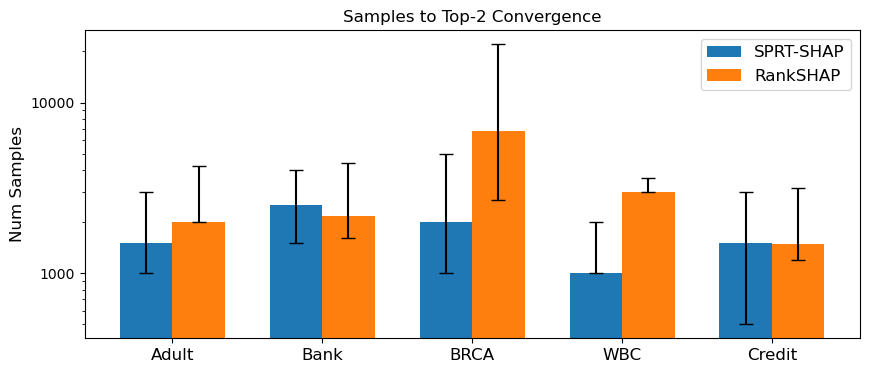

In [79]:
bar_width = 0.35
dataNames = ["Adult", "Bank", "BRCA", "WBC", "Credit"]
methodNames = ["SPRT-SHAP", "RankSHAP"]

# Index array for each group
index = np.arange(5)

# Plotting
fig, ax = plt.subplots(figsize=(10,4))

# Plotting bars for each row
for i in range(2):
    ax.bar(index + i * bar_width, shap_n_samples[i], bar_width, label=methodNames[i])
    ax.errorbar(index + i * bar_width, shap_n_samples[i], yerr=(shap_n_samples[i]-shap_q1[i], shap_q3[i]-shap_n_samples[i]), color="black", ls="none", capsize=5)

# Adding labels
ax.set_ylabel('Num Samples', fontsize="large")
ax.set_title('Samples to Top-2 Convergence', fontsize="large")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dataNames, fontsize="large")
ax.set_yscale('log')

ax.yaxis.set_major_formatter(ScalarFormatter())

ax.legend(fontsize="large")
plt.savefig(join(dir_path, "Experiments", "Figures", "n_samples_vs_kshap.png"), bbox_inches="tight")
plt.show()

